# Potential Talents - An Apziva Project (#3)

# Proceed to the [previous notebook](potential_talents_p1.ipynb) to view the EDA and initial NLP work.

# Modeling

By Samuel Alter

Apziva: 6bImatZVlK6DnbEo

## Project Overview

We are working with a talent sourcing and management company to help them surface candidates that are a best fit for their human resources job post. We are using a dataset of job candidates' job titles, their location, and their number of LinkedIn connections.

### Goals

Produce a probability, between 0 and 1, of how closely the candidate fits the job description of **"Aspiring human resources"** or **"Seeking human resources."** After an initial recommendation pulls out a candidate(s) to be starred for future consideration, the recommendation will be re-run and new "stars" will be awarded.

To help predict how the candidates fit, we are tracking the performance of two success metrics:
* Rank candidates based on a fitness score
* Re-rank candidates when a candidate is starred

We also need to do the following:
* Explain how the algorithm works and how the ranking improves after each starring iteration
* How to filter out candidates which should not be considered at all
* Determine a cut-off point (if possible) that would work for other roles without losing high-potential candidates
* Ideas to explore on automating this procedure to reduce or eliminate human bias

### The Dataset

| Column | Data Type | Comments |
|---|---|---|
| `id` | Numeric | Unique identifier for the candidate |
| `job_title` | Text | Job title for the candidate |
| `location` | Text | Geographic location of the candidate |
| `connections` | Text | Number of LinkedIn connections for the candidate |

Connections over 500 are encoded as "500+". Some do not have specific locations listed and just had their country, so I substituted capitol cities or geographic centers to represent those countries.

# Imports and Helper Functions

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
from torchview import draw_graph
import torch.nn.functional as F
from collections import defaultdict

In [2]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    import numpy as np
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    
    return random_state

In [3]:
seed=rand_gen()
seed

7909

In [4]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x12B30C820

In [5]:
def get_variable_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [name for name, val in callers_local_vars if val is var]

def fileDaterSaver(location: str,
                   filetype: str,
                   object_,
                   extra: str = '',
                   verbose: bool = True):

    '''
    Function that gets a timestamped filename and saves it
    to a user-specified location.

    Parameters:
    -----------
    location: str - The location where the file will be saved.
    filetype: str - The type of the file to save ('csv' or 'json').
    object_: The object to be saved. Should be a pandas DataFrame
        for 'csv' or serializable for 'json'.
    extra: str - Additional string to include in the filename.
    verbose: bool - Whether to print verbose messages.
    '''

    # get current date and time
    current_datetime = datetime.now()

    # print current date and time to check
    if verbose:
        print('current_datetime:', current_datetime)

    # format the datetime for a filename
    datetime_suffix = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # create filename with the datetime suffix
    if extra != '':
        file_name = f'{location}{extra}_{datetime_suffix}.{filetype}'
    else:
        file_name = f'{location}{datetime_suffix}.{filetype}'

    # print file name
    if verbose:
        print(file_name)

    # save object
    if filetype == 'csv':
        object_.to_csv(file_name, index=True)
    elif filetype == 'json':
        with open(file_name, 'w') as file:
            file.write(json.dumps(object_, default=str))
    else:
        raise ValueError("Unsupported file type. Use 'csv' or 'json'.")

    # confirm save
    file_path = Path(file_name)
    if file_path.exists():
        variable_name = get_variable_name(object_)
        if variable_name:
            print(f'Successfully saved {variable_name[0]} to {file_path}')
        else:
            print(f'Successfully saved object to {file_path}')
    else:
        print("File save error.")

# Tutorial 

taken from here: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

Quickstart

This section runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

Working with data

PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.

```python
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
```

PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets. For this tutorial, we will be using a TorchVision dataset.

The torchvision.datasets module contains Dataset objects for many real-world vision data like CIFAR, COCO (full list here). In this tutorial, we use the FashionMNIST dataset. Every TorchVision Dataset includes two arguments: transform and target_transform to modify the samples and labels respectively.

In [6]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [7]:
batch_size = 64

# create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Creating Models

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU or MPS if available.

In [8]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Optimizing the Model Parameters

To train a model, we need a loss function and an optimizer.

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model’s performance against the test dataset to ensure it is learning.

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.

In [12]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.292368  [   64/60000]
loss: 2.289333  [ 6464/60000]
loss: 2.269571  [12864/60000]
loss: 2.270055  [19264/60000]
loss: 2.262659  [25664/60000]
loss: 2.221229  [32064/60000]
loss: 2.231440  [38464/60000]
loss: 2.194764  [44864/60000]
loss: 2.198118  [51264/60000]
loss: 2.171618  [57664/60000]
Test Error: 
 Accuracy: 40.3%, Avg loss: 2.164038 

Epoch 2
-------------------------------
loss: 2.164637  [   64/60000]
loss: 2.162565  [ 6464/60000]
loss: 2.106158  [12864/60000]
loss: 2.133003  [19264/60000]
loss: 2.090532  [25664/60000]
loss: 2.016371  [32064/60000]
loss: 2.052718  [38464/60000]
loss: 1.970228  [44864/60000]
loss: 1.984091  [51264/60000]
loss: 1.920510  [57664/60000]
Test Error: 
 Accuracy: 54.7%, Avg loss: 1.914506 

Epoch 3
-------------------------------
loss: 1.930885  [   64/60000]
loss: 1.910155  [ 6464/60000]
loss: 1.799560  [12864/60000]
loss: 1.857352  [19264/60000]
loss: 1.745834  [25664/60000]
loss: 1.681149  [32064/600

Saving Models

A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

In [13]:
path=Path("../joblib/3_testmodel.pth")
torch.save(model.state_dict(), path)
print(f"Saved PyTorch Model State to {path}")

Saved PyTorch Model State to ../joblib/3_testmodel.pth


Loading Models

The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [14]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load(path, weights_only=True))

<All keys matched successfully>

This model can now be used to make predictions.

In [15]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


Tensor tutorial here: https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html

Datasets & dataloaders here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [16]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

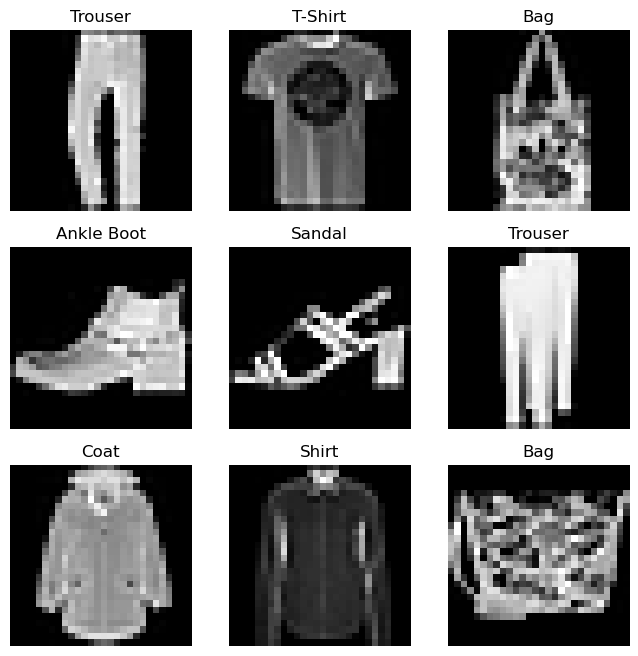

In [17]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Optimizing model parameters

https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

Here is a tutorial about using RankNet in PyTorch that I am also following, especially for help on constructing the neural network:

https://medium.com/@mandeep0405/learning-to-rank-ranknet-simplified-5d7f7334133d

# Learning to Rank (LTR) systems 

[RankNet](https://icml.cc/Conferences/2015/wp-content/uploads/2015/06/icml_ranking.pdf) is an influential algorithm that is designed to rank items given an objective. LTR systems are used for information retrieval, which is crucial for search engines, recommender systems like on Netflix or Amazon, travel agencies, and online advertising.

You can learn more about LTR systems from [this](https://towardsdatascience.com/learning-to-rank-a-complete-guide-to-ranking-using-machine-learning-4c9688d370d4) Medium post by [Francesco Casalegno](https://medium.com/@francesco.casalegno).

RankNet uses a "pairwise" method of training, meaning it predices which item in a pair should be ranked higher based on a probabilistic model. With pairs of items, using RankNet makes our task a binary classification problem.

Example PyTorch setup with RankNet from [here](https://medium.com/@mandeep0405/learning-to-rank-ranknet-simplified-5d7f7334133d):

In [18]:
# define RankNet
class RankNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input = nn.Linear(input_size, hidden_size)
        self.hidden = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.activation = nn.ReLU()

    def forward(self, x1, x2):
        # Process first item
        x1_in = self.activation(self.input(x1))
        h1 = self.activation(self.hidden(x1_in))
        out1 = self.output(h1)

        # Process second item
        x2_in = self.activation(self.input(x2))
        h2 = self.activation(self.hidden(x2_in))
        out2 = self.output(h2)

        # Compute difference
        return out1 - out2

In [19]:
# define hyperparameters
input_size = 10  # dimension of item feature vector e.g., relevance_to_genre, rating etc.
hidden_size = 16 # hidden layer params
learning_rate = 0.01

# instantiate model
model = RankNet(input_size, hidden_size)

# loss function and optimizer
criterion = nn.BCEWithLogitsLoss() # applies sigmoid
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
# example usage
x1 = torch.randn(1, input_size)  # Feature vector for item 1
x2 = torch.randn(1, input_size)  # Feature vector for item 2
target = torch.tensor([[1.0]])  # 1 if x1 should be ranked higher, 0 otherwise

train_loss = []
for epoch in range(100):
    model.train()
    
    # clear gradients
    optimizer.zero_grad()
    
    # Forward pass
    diff = model(x1, x2)
    
    # Compute loss
    loss = criterion(diff, target)
    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    
    train_loss.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.795262336730957
Epoch 10, Loss: 0.27946966886520386
Epoch 20, Loss: 0.014517279341816902
Epoch 30, Loss: 0.0006131730042397976
Epoch 40, Loss: 0.00011050953617086634
Epoch 50, Loss: 5.1772742153843865e-05
Epoch 60, Loss: 3.779145117732696e-05
Epoch 70, Loss: 3.314453351777047e-05
Epoch 80, Loss: 3.124208888038993e-05
Epoch 90, Loss: 3.0266131943790242e-05


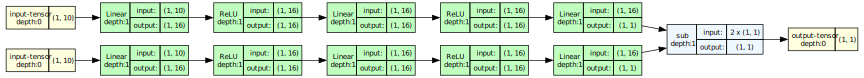

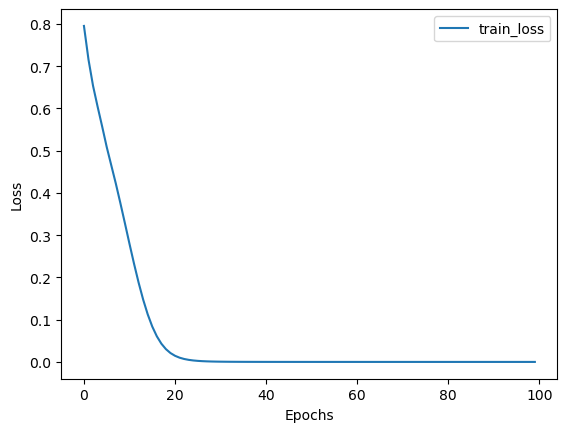

In [21]:
# plot Loss
plt.plot(train_loss, label='train_loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show

# plot model architecture
model_graph = draw_graph(model, input_data = [x1,x2], graph_dir = "LR", save_graph = True, graph_name="RankNet")
model_graph.visual_graph

from here: https://github.com/yanshanjing/RankNet-Pytorch/blob/master/RankNet-Pytorch.py

In [22]:
# set random seed
torch.manual_seed(seed)

In [23]:
# setup device for Apple Silicon or NVIDIA
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

class RankNet(nn.Module):
    def __init__(self, num_feature):
        super(RankNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear( num_feature, 512),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )
        self.output_sig = nn.Sigmoid()

    def forward(self, input_1,input_2):
        input_1, input_2 = input_1.to(device), input_2.to(device)
        s1 = self.model(input_1)
        s2 = self.model(input_2)
        out = self.output_sig(s1 - s2)
        return out
    
    def predict(self, input_):
        s = self.model(input_)
        return s

In [24]:
# generate random data
n_sample = 30000
n_feature = 300
data1 = torch.rand((n_sample,n_feature)).to(device)
data2 = torch.rand((n_sample, n_feature)).to(device)
y = torch.rand((n_sample, 1)).to(device)

# model, organizer, and loss function setup
rank_model = RankNet(num_feature=n_feature).to(device)
optimizer = torch.optim.Adam(rank_model.parameters())
loss_fun = torch.nn.BCELoss().to(device)

# training loop initialization
epoch = 1000
losses = []

for i in range(epoch):
    rank_model.train()
    rank_model.zero_grad()
    y_pred = rank_model(data1, data2)
    loss = loss_fun(y_pred, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if i % 250 == 0:
        print(f'Epoch {i}, Loss: {loss.item()}')

Epoch 0, Loss: 0.6969847083091736
Epoch 250, Loss: 0.613135576248169
Epoch 500, Loss: 0.5883915424346924
Epoch 750, Loss: 0.5799568891525269


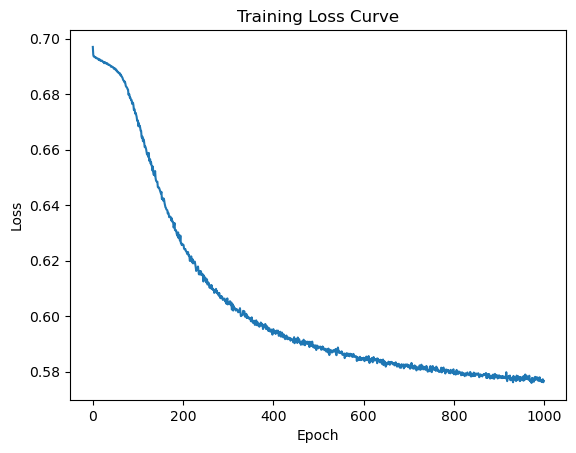

In [25]:
# plot loss curve
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

## RankNet NN

#### `device` Setup

In [62]:
# get cpu, gpu or mps device for training.
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using mps device


#### `RankNet` class

RankNet, a pairwise ranking algorithm, is differentiated in its ranking methodology rather than the specifics of its architecture. It is defined by:
* **Pairwise comparison** of pairs of inputs
* **Sigmoid-based** probability output
* **Loss function** involving **Binary Cross-Entropy Loss** to compute error between predicted probabilities and true pairwise labels
* **Backpropagation and gradient decent** allows for training and updating weights using gradients calculated from the pairwise ranking loss

The architecture is not fixed and we can:
* Add or remove layers
* Change the number of neurons in the hidden layers
* Adjust activation functions
* Change dropout rates

In [51]:
class RankNet(nn.Module):
    def __init__(self, n_feature):
        super(RankNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_feature, 512),
            nn.BatchNorm1d(512), # normalization
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256), # another round of normalization
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )
        
    def forward(self, input_1, input_2):
        # define inputs and handle potentail length issue
        input_1 = input_1.to(device).float().unsqueeze(0) if len(input_1.shape) == 1 else input_1
        input_2 = input_2.to(device).float().unsqueeze(0) if len(input_2.shape) == 1 else input_2
        s1 = self.model(input_1)
        s2 = self.model(input_2)
        return s1 - s2

#### Load training and testing data

Now that we have the neural network defined, we need to load the training files saved as parquet from the end of Part 1 of the project.

In [52]:
# load data
train_data = pd.read_parquet('../joblib/3_pairs_train.parquet', engine='pyarrow')
test_data = pd.read_parquet('../joblib/3_pairs_test.parquet', engine='pyarrow')

In [53]:
# load data from parquet files
train_input_1 = torch.tensor(train_data['input_1'].tolist(), dtype=torch.float32)
train_input_2 = torch.tensor(train_data['input_2'].tolist(), dtype=torch.float32)
train_labels = torch.tensor(train_data['label'].tolist(), dtype=torch.float32)

# preserve IDs for later use (but exclude them from model input)
train_ids_1 = train_data['id_1'].tolist()
train_ids_2 = train_data['id_2'].tolist()

test_input_1 = torch.tensor(test_data['input_1'].tolist(), dtype=torch.float32)
test_input_2 = torch.tensor(test_data['input_2'].tolist(), dtype=torch.float32)
test_labels = torch.tensor(test_data['label'].tolist(), dtype=torch.float32)

test_ids_1 = test_data['id_1'].tolist()
test_ids_2 = test_data['id_2'].tolist()

# create TensorDataset without IDs (they're stored separately)
train_dataset = TensorDataset(train_input_1, train_input_2, train_labels)
test_dataset = TensorDataset(test_input_1, test_input_2, test_labels)

# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Training loop

##### Hyperparameter definitions

In [66]:
# retrieve shape of tensors from file produced in Part 1
with open('../joblib/3_n_feature.txt', 'r') as file:
    num_features = int(file.read())
    print('num_features:',num_features)

n_feature = num_features
learning_rate = 0.01
batch_size = 64
epochs = 25

num_features: 384


##### Instantiate model and define loss function and optimizer

In [67]:
def train(model, train_loader, loss_fn, optimizer, device, epochs=50):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in train_loader:
            input_1, input_2, labels = batch
            input_1, input_2, labels = input_1.to(device), input_2.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(input_1, input_2).squeeze()

            # Calculate loss
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track loss
            epoch_loss += loss.item()

            # Calculate accuracy (threshold 0.5 for binary classification)
            predicted = torch.sigmoid(outputs) > 0.5
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_accuracy = correct_predictions / total_samples
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}")

In [68]:
rank_net = RankNet(n_feature=n_feature).to(device)
loss_fn = nn.BCEWithLogitsLoss() # binary cross-entropy loss with logits
optimizer = torch.optim.Adam(rank_net.parameters(), lr=learning_rate)

In [69]:
train(rank_net, train_loader, loss_fn, optimizer, device, epochs)

Epoch [1/25], Loss: 0.7295, Accuracy: 0.5777
Epoch [2/25], Loss: 0.6382, Accuracy: 0.6335
Epoch [3/25], Loss: 0.6170, Accuracy: 0.6454
Epoch [4/25], Loss: 0.5969, Accuracy: 0.6643
Epoch [5/25], Loss: 0.5884, Accuracy: 0.6704
Epoch [6/25], Loss: 0.5688, Accuracy: 0.6825
Epoch [7/25], Loss: 0.5755, Accuracy: 0.6774
Epoch [8/25], Loss: 0.5640, Accuracy: 0.6849
Epoch [9/25], Loss: 0.5628, Accuracy: 0.6977
Epoch [10/25], Loss: 0.5537, Accuracy: 0.6898
Epoch [11/25], Loss: 0.5519, Accuracy: 0.6986
Epoch [12/25], Loss: 0.5465, Accuracy: 0.7000
Epoch [13/25], Loss: 0.5464, Accuracy: 0.6949
Epoch [14/25], Loss: 0.5464, Accuracy: 0.7007
Epoch [15/25], Loss: 0.5504, Accuracy: 0.6933
Epoch [16/25], Loss: 0.5431, Accuracy: 0.7026
Epoch [17/25], Loss: 0.5384, Accuracy: 0.6982
Epoch [18/25], Loss: 0.5417, Accuracy: 0.7019
Epoch [19/25], Loss: 0.5400, Accuracy: 0.7024
Epoch [20/25], Loss: 0.5443, Accuracy: 0.7082
Epoch [21/25], Loss: 0.5359, Accuracy: 0.6984
Epoch [22/25], Loss: 0.5348, Accuracy: 0.70

#### Evaluate model and match IDs with predictions

In [70]:
def test_with_ids(model, test_loader, loss_fn, device, test_ids_1, test_ids_2, batch_size):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct_predictions = 0
    total_samples = 0

    predictions = []
    id_pairs = []  # Store the associated IDs for each prediction

    with torch.no_grad():
        for idx, batch in enumerate(test_loader):
            input_1, input_2, labels = batch
            input_1, input_2, labels = input_1.to(device), input_2.to(device), labels.to(device)

            # Forward pass
            outputs = model(input_1, input_2).squeeze()

            # Calculate loss
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            # Calculate accuracy
            predicted = torch.sigmoid(outputs) > 0.5
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Store predictions and IDs
            predicted_probs = torch.sigmoid(outputs).cpu().numpy()
            predictions.extend(predicted_probs)

            # Track the associated ID pairs for each batch
            id_pairs.extend(zip(test_ids_1[idx * batch_size:(idx + 1) * batch_size],
                                test_ids_2[idx * batch_size:(idx + 1) * batch_size]))

    # Calculate final metrics
    test_accuracy = correct_predictions / total_samples
    avg_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Match predictions to IDs
    results = pd.DataFrame({
        'id_1': [pair[0] for pair in id_pairs],
        'id_2': [pair[1] for pair in id_pairs],
        'predicted_prob': predictions,
    })

    return results

In [71]:
results = test_with_ids(rank_net, test_loader, loss_fn, device, test_ids_1, test_ids_2, batch_size)
print(results.head())  # Display the first few results

Test Loss: 0.6462, Test Accuracy: 0.5998
   id_1  id_2  predicted_prob
0    73   101        0.385931
1    33    57        0.559425
2    47   100        0.604689
3    20    75        0.694083
4    27    32        0.737415


#### Dataloader and batch processing setup

In [ ]:
# setup batch processing and data loader
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

#### Optimizer and Loss Initialization

In [34]:
# instantiate model, optimizer, and loss function (aka criterion)
model = RankNet(n_feature=n_feature).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCEWithLogitsLoss().to(device)

print(model)

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
RankNet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
  (output_sig): Sigmoid()
)


#### Instantiate model

In [ ]:
n_feature = job_titles[0].shape[0]  # assuming all SBERT embeddings have the same shape
model = RankNet(n_feature=n_feature).to(device)

In [ ]:
# initialize a dictionary to count the number of "wins" for each candidate
rank_scores = defaultdict(int)

# aggregate results: count how often each ID is ranked higher
for id_1, id_2, prediction in results:
    if prediction == 1:
        rank_scores[id_1] += 1
    else:
        rank_scores[id_2] += 1

# sort candidates by their score (higher is better)
final_ranking = sorted(rank_scores.items(), key=lambda x: x[1], reverse=True)

# print or convert to DataFrame
for rank, (candidate_id, score) in enumerate(final_ranking, 1):
    print(f"Rank {rank}: Candidate ID {candidate_id} with score {score}")

In [31]:
# setup datasets for modeling
# training_data = 
# test_data = 